In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
##from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

In [2]:
token_path = 'C:/Users/ASUS/Desktop/ICG_US/Flickr8k_text/Flickr8k.token.txt'
train_images_path = 'C:/Users/ASUS/Desktop/ICG_US/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = 'C:/Users/ASUS/Desktop/ICG_US/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset'

#doc="Hello"
doc = open(token_path,'r').read()
print(doc[:410])



icg1 (1).jpg#0	A player is catching a ball.
icg1 (1).jpg#1	Some players are sitting on the chair.	
icg1 (1).jpg#2	A player wearing light sky blue Tshirt catching the ball.	
icg1 (1).jpg#3	There is an advertising board.
icg1 (1).jpg#4	There are white chair beside ground.
icg1 (2).jpg#0	An Indian Player is running for bowling.
icg1 (2).jpg#1	Crowd of people are cheering.
icg1 (2).jpg#2	There is an advertising


In [3]:
descriptions = dict()

for line in doc.split('\n'):
        tokens = line.split()
        #print(tokens)
        if len(line) > 2:
          image_id = tokens[0]+" "+tokens[1].split('.')[0]
          print(image_id)
          image_desc = ' '.join(tokens[2:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)


icg1 (1)
icg1 (1)
icg1 (1)
icg1 (1)
icg1 (1)
icg1 (2)
icg1 (2)
icg1 (2)
icg1 (2)
icg1 (2)
icg1 (3)
icg1 (3)
icg1 (3)
icg1 (3)
icg1 (3)
icg1 (4)
icg1 (4)
icg1 (4)
icg1 (4)
icg1 (4)
icg1 (5)
icg1 (5)
icg1 (5)
icg1 (5)
icg1 (5)
icg1 (6)
icg1 (6)
icg1 (6)
icg1 (6)
icg1 (6)
icg1 (7)
icg1 (7)
icg1 (7)
icg1 (7)
icg1 (7)
icg1 (8)
icg1 (8)
icg1 (8)
icg1 (8)
icg1 (8)
icg1 (9)
icg1 (9)
icg1 (9)
icg1 (9)
icg1 (9)
icg1 (10)
icg1 (10)
icg1 (10)
icg1 (10)
icg1 (10)
icg1 (11)
icg1 (11)
icg1 (11)
icg1 (11)
icg1 (11)
icg1 (12)
icg1 (12)
icg1 (12)
icg1 (12)
icg1 (12)
icg1 (13)
icg1 (13)
icg1 (13)
icg1 (13)
icg1 (13)
icg1 (14)
icg1 (14)
icg1 (14)
icg1 (14)
icg1 (14)
icg1 (15)
icg1 (15)
icg1 (15)
icg1 (15)
icg1 (15)
icg1 (16)
icg1 (16)
icg1 (16)
icg1 (16)
icg1 (16)
icg1 (17)
icg1 (17)
icg1 (17)
icg1 (17)
icg1 (17)
icg1 (18)
icg1 (18)
icg1 (18)
icg1 (18)
icg1 (18)
icg1 (19)
icg1 (19)
icg1 (19)
icg1 (19)
icg1 (19)
icg1 (20)
icg1 (20)
icg1 (20)
icg1 (20)
icg1 (20)
icg1 (21)
icg1 (21)
icg1 (21)
icg1 (21)
icg1 

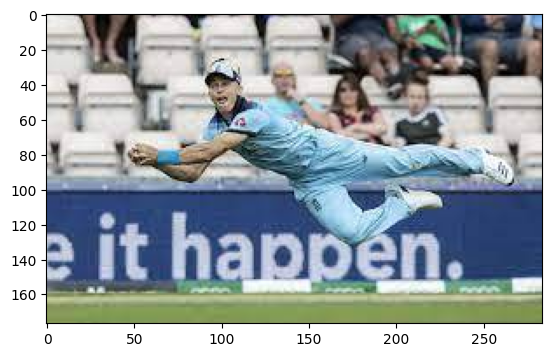

['A player is catching a ball.',
 'Some players are sitting on the chair.',
 'A player wearing light sky blue Tshirt catching the ball.',
 'There is an advertising board.',
 'There are white chair beside ground.']

In [4]:
pic = 'icg1 (1).jpg'
x=plt.imread(images_path+'/'+pic)
plt.imshow(x)
plt.show()
descriptions['icg1 (1)']

In [5]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 466


In [6]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [7]:
print(new_descriptions)

icg1 (1) A player is catching a ball.
icg1 (1) Some players are sitting on the chair.
icg1 (1) A player wearing light sky blue Tshirt catching the ball.
icg1 (1) There is an advertising board.
icg1 (1) There are white chair beside ground.
icg1 (2) An Indian Player is running for bowling.
icg1 (2) Crowd of people are cheering.
icg1 (2) There is an advertising board.
icg1 (2) A player wearing blue T-shirt is running in the ground.
icg1 (2) A man is standing on the green Grass.
icg1 (3) A Player is throwing a ball.
icg1 (3) A player wearing blue T-shirt is throwing the ball.
icg1 (3) There is green grass in the ground.
icg1 (3) A player is holding a white ball.
icg1 (3) A player worn a white shoe.
icg1 (4) A player is trying to catch a ball.
icg1 (4) A player wearing blue T-shirt is holding the ball.
icg1 (4) A right hand bowler standing on the ground.
icg1 (4) A player is on the pitch.
icg1 (4) A player is trying to catch a ball.
icg1 (5) A wicketkeeper is catching a ball.
icg1 (5) A pla

In [8]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [9]:
img = glob.glob(images_path + '/*.jpg')
print(img)
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i.split('\\')[1] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    #print(i.split('/')[5])
    if i.split('\\')[1] in test_images: 
        test_img.append(i)

['C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (1).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (10).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (100).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (101).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (11).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (12).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (13).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (14).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (15).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (16).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (17).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (18).jpg', 'C

In [10]:
for i in img: 
    if i.split('/')[5] in train_images:
        print(i)

In [11]:
for i in img:
    print(i)

C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (1).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (10).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (100).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (101).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (11).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (12).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (13).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (14).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (15).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (16).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (17).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (18).jpg
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flic

In [12]:
i.split('\\')[1]

'icg1 (99).jpg'

In [13]:
print(train_img)

['C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (1).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (10).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (11).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (12).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (13).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (14).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (15).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (16).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (17).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (18).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (19).jpg', 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (2).jpg', 'C:/U

In [14]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0]+" "+tokens[1].split('.')[0], tokens[2:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [15]:
print(train_descriptions)

{'icg1 (1)': ['startseq A player is catching a ball. endseq', 'startseq Some players are sitting on the chair. endseq', 'startseq A player wearing light sky blue Tshirt catching the ball. endseq', 'startseq There is an advertising board. endseq', 'startseq There are white chair beside ground. endseq'], 'icg1 (2)': ['startseq An Indian Player is running for bowling. endseq', 'startseq Crowd of people are cheering. endseq', 'startseq There is an advertising board. endseq', 'startseq A player wearing blue T-shirt is running in the ground. endseq', 'startseq A man is standing on the green Grass. endseq'], 'icg1 (3)': ['startseq A Player is throwing a ball. endseq', 'startseq A player wearing blue T-shirt is throwing the ball. endseq', 'startseq There is green grass in the ground. endseq', 'startseq A player is holding a white ball. endseq', 'startseq A player worn a white shoe. endseq'], 'icg1 (4)': ['startseq A player is trying to catch a ball. endseq', 'startseq A player wearing blue T-s

In [16]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [17]:
print(all_train_captions)

['startseq A player is catching a ball. endseq', 'startseq Some players are sitting on the chair. endseq', 'startseq A player wearing light sky blue Tshirt catching the ball. endseq', 'startseq There is an advertising board. endseq', 'startseq There are white chair beside ground. endseq', 'startseq An Indian Player is running for bowling. endseq', 'startseq Crowd of people are cheering. endseq', 'startseq There is an advertising board. endseq', 'startseq A player wearing blue T-shirt is running in the ground. endseq', 'startseq A man is standing on the green Grass. endseq', 'startseq A Player is throwing a ball. endseq', 'startseq A player wearing blue T-shirt is throwing the ball. endseq', 'startseq There is green grass in the ground. endseq', 'startseq A player is holding a white ball. endseq', 'startseq A player worn a white shoe. endseq', 'startseq A player is trying to catch a ball. endseq', 'startseq A player wearing blue T-shirt is holding the ball. endseq', 'startseq A right ha

In [55]:
word_count_threshold = 25
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 28


In [57]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [20]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 16


In [58]:
glove_path = 'C:/Users/ASUS/Desktop/ICG_US/glove.6B/'

embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [59]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [60]:
model = InceptionV3(weights='imagenet')
#model = DenseNet201(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

In [61]:
def preprocess(image_path):
    #img = image.load_img(image_path, target_size=(299, 299))
    img = tf.keras.utils.load_img(image_path, target_size=(299, 299))
    #for densenet
    #img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [62]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    #print(img)
    encoding_test[img] = encode(img)

1/1 [==============================] - 0s 144ms/step


In [63]:
train_features

{'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (1).jpg': array([0.07453209, 0.05707407, 0.42477313, ..., 0.14669305, 0.02409131,
        0.20153975], dtype=float32),
 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (10).jpg': array([0.12721668, 0.48201567, 0.05563467, ..., 0.6774147 , 0.01359206,
        0.26411057], dtype=float32),
 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (11).jpg': array([0.39241415, 0.00802782, 0.16695055, ..., 0.0446357 , 0.07241297,
        0.48003322], dtype=float32),
 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (12).jpg': array([0.10589314, 0.14757589, 0.12946947, ..., 0.11359066, 0.42504466,
        0.21567465], dtype=float32),
 'C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\\icg1 (13).jpg': array([0.12812725, 0.23388296, 0.15828454, ..., 0.2727784 , 0.14167757,
        0.4806851 ], dtype=float32),
 'C:/Users/ASUS/Desktop/ICG_US/Flick

In [64]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.05)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.05)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 16, 200)      5800        ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

In [65]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [66]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [67]:
from keras_preprocessing.sequence import pad_sequences

In [68]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[images_path + '\\' + key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [69]:
#  photo = photos['C:/Users/ASUS/Desktop/ICG/Flicker8k_Dataset/Flicker8k_Dataset' + '/' + key + '.jpg']
for i in train_features:
    print(i, train_features[i])

C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (1).jpg [0.07453209 0.05707407 0.42477313 ... 0.14669305 0.02409131 0.20153975]
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (10).jpg [0.12721668 0.48201567 0.05563467 ... 0.6774147  0.01359206 0.26411057]
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (11).jpg [0.39241415 0.00802782 0.16695055 ... 0.0446357  0.07241297 0.48003322]
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (12).jpg [0.10589314 0.14757589 0.12946947 ... 0.11359066 0.42504466 0.21567465]
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (13).jpg [0.12812725 0.23388296 0.15828454 ... 0.2727784  0.14167757 0.4806851 ]
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (14).jpg [0.14440277 0.12622075 0.1445982  ... 0.13769154 0.5174215  0.29163784]
C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset\icg1 (15).jpg [0.0415632  0.15

In [70]:
epochs = 100
batch_size = 4
steps = len(train_descriptions)//batch_size
print(steps)

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

19
Epoch 1/100
19/19 [==============================] - 10s 132ms/step - loss: 2.8025
Epoch 2/100
19/19 [==============================] - 2s 128ms/step - loss: 2.3150
Epoch 3/100
19/19 [==============================] - 3s 131ms/step - loss: 2.0153
Epoch 4/100
19/19 [==============================] - 2s 127ms/step - loss: 1.8213
Epoch 5/100
19/19 [==============================] - 2s 130ms/step - loss: 1.7151
Epoch 6/100
19/19 [==============================] - 2s 126ms/step - loss: 1.6276
Epoch 7/100
19/19 [==============================] - 2s 128ms/step - loss: 1.5044
Epoch 8/100
19/19 [==============================] - 2s 125ms/step - loss: 1.4030
Epoch 9/100
19/19 [==============================] - 2s 126ms/step - loss: 1.3558
Epoch 10/100
19/19 [==============================] - 2s 126ms/step - loss: 1.3694
Epoch 11/100
19/19 [==============================] - 2s 126ms/step - loss: 1.3019
Epoch 12/100
19/19 [==============================] - 2s 124ms/step - loss: 1.2325
Epoch 13/

In [71]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [73]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

1/1 [==============================] - 0s 224ms/step


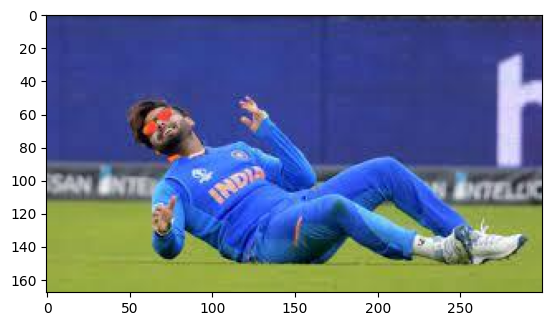

Greedy: A is the
Beam Search, K = 3: A is the
Beam Search, K = 5: is on the ground.
Beam Search, K = 7: is on the ground.


In [78]:
#pic = list(encoding_test.keys())[1]
pic='C:/Users/ASUS/Desktop/ICG_US/Flicker8k_Dataset/Flicker8k_Dataset/icg1 (17).jpg'
ans =encode(pic)
image = ans.reshape((1,2048))
x=plt.imread(pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))